## Recurrent Neural Networks

Author: Calvin Chan 

### Introduction 

In this final notebook we will look at an advance model known as Recurrent Neural Networks or RNNs. We will be utilizing Gated Reccurent Units or (GRUs) in our model. Since our data consists of time series, we expect RNNs to work much better since they are meant for processing time series data such as ours. First we will import our full data set and add some minor changes such as reducing the data from multiclass to binary classification. 

At the end of this notebook, we incldued a summary to go through how our model helps with the problem space we are in, what are some of the limitations that we encountered, and possible some next steps if this process were on going. 

### Table of Contents
- [Full Data Import](#import)
    - Imported the full data set for modelling
- [Data Preprocessing](#preprocessing)
    - Preprocessed signals by removing baseline wandering and high frequency powerline interference
- [First Model](#first)
    - First test model, small epochs, using sparse categorical entropy and softmax, and low learning rate
- [Second Model](#model2)
    - Increased learning rate and epochs, using binary cross entropy and sigmoid
- [Third Model](#third)
    - Maintained structure of second model but adjusted threshold of binary classification to increase recall
- [GridSearchCV](#gridsearch)
    - Testing combinations of epochs, batch size, and learning rate
- [Fourth Model](#fourth)
    - Model from best parameters in gridsearch 
- [Summary](#summary)
    - Summary about project results throughout the notebooks

Let's begin by importing our required packages.

In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/ecgcap/bin/python3.10


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle
import load_functions as f
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.layers import Dense, Dropout, GRU, BatchNormalization, LeakyReLU
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

<a id='import'></a>
### Full Data Import

We will read in our full data set now.

In [3]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [4]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [5]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

<a id='preprocessing'></a>
### Data Preprocessing 

We need to do some preprocessing of our data, that is using our function in `load_functions.py` to make the target classes binary. Then using our functions for ECG cleaning (`ecg_cleaning.py`), we denoise them before they are fed into respective models. 



#### Binary Classification

In [6]:
# Transform our target column into binary classes
y = y.apply(lambda x: f.binary(x))

In [7]:
# Sanity check
y.value_counts()

diagnostic_superclass
ABNO    8645
NORM    7032
Name: count, dtype: int64

With the number of classes defined, we have to label them using numbers before we can feed them into models. We do this using `LabelEncoder` from scikit-learn. 

In [8]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

# Transform target column 
y = label.transform(y)

In [9]:
# Checking how our label is encoded 
label.transform(['ABNO', 'NORM'])

array([0, 1])

#### Signal Denoising using `ecg_cleaning.py`

Here, we denoise our signal using functions we created that implements Fourier Tranforms for signal cleaning. We have to specify frequencies in which we want to take out for baseline wandering and high frequencies, including powerline interference. 

In [10]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal

signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

For the model to work properly, it requires our time series signals in a 3D shape. Therefore, we reshape our data. 

In [11]:
signal_pli.shape

(15677, 1000)

In [12]:
# Reshape it into 3D 
signal_pli = signal_pli.reshape(-1, 1000, 1).astype("float")

In [13]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000, 1), (12541,))

In [14]:
X_test.shape, y_test.shape

((3136, 1000, 1), (3136,))

<a id='first'></a>
### First Model 

In this first model, we will use a softmax output layer and sparse categorical cross entropy.

In [15]:
rnn_model = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(2, activation='softmax')],
)

In [18]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Setting our early stop and training the model. 

In [28]:
# Parameters
epoch = 10

In [19]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=epoch, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 90s 254ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.5995 - val_loss: 0.6217 - val_sparse_categorical_accuracy: 0.6438
Epoch 2/10
353/353 [==============================] - 121s 344ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.5396 - val_sparse_categorical_accuracy: 0.7291
Epoch 3/10
353/353 [==============================] - 146s 415ms/step - loss: 0.5005 - sparse_categorical_accuracy: 0.7636 - val_loss: 1.1612 - val_sparse_categorical_accuracy: 0.5482
Epoch 4/10
353/353 [==============================] - 113s 319ms/step - loss: 0.4597 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.4437 - val_sparse_categorical_accuracy: 0.7793
Epoch 5/10
353/353 [==============================] - 161s 449ms/step - loss: 0.4464 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.4403 - val_sparse_categorical_accuracy: 0.7920
Epoch 6/10
353/353 [==============================] - 140s 398ms/step - loss: 0.4

In [20]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1000, 16)          912       
                                                                 
 batch_normalization (BatchN  (None, 1000, 16)         64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1000, 16)          0         
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [25]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][np.argmax(history.history["sparse_categorical_accuracy"])]
result = rnn_model.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8208
Test Accuracy: 0.8438


Looking at our training and testing accuracy we see that using RNNs broke us through into the +80% range. This is a great milestone for us. Let's do some more evaluation. 

In [138]:
epochs = range(1, epoch)

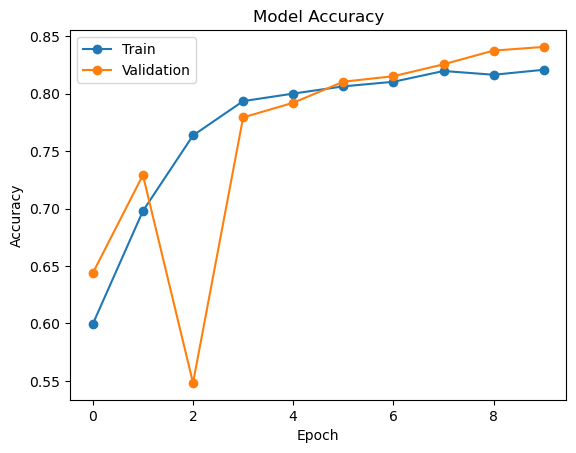

In [29]:
# Plotting accuracy function 
plt.plot(epochs, history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

We see that the validation accuracy fluctuates up and down while the training accuracy has a clear increase and then a decrease. Given that we allowed for restoring the best weights using the `restore_best_weights` parameter in our callbacks, our model currently holds the best weight from all the epochs so far. 

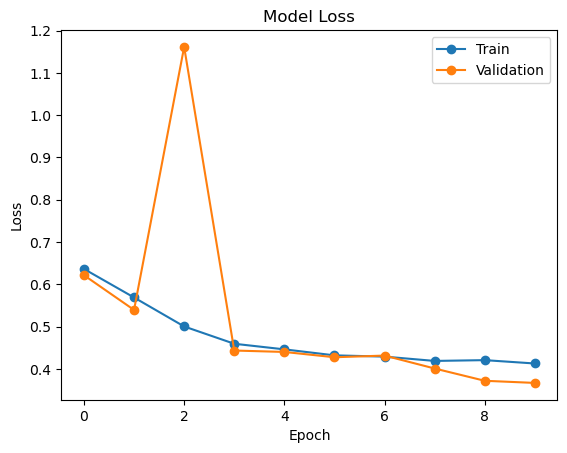

In [32]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

Reflecting a similar pattern as accuracy, the loss score also fluctuates while the training score steadily decreases. 

In [38]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

98/98 [==============================] - 3s 26ms/step


In [39]:
# Classification report 
cr = classification_report(y_test, y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1729
           1       0.81      0.84      0.83      1407

    accuracy                           0.84      3136
   macro avg       0.84      0.84      0.84      3136
weighted avg       0.84      0.84      0.84      3136



Looking at the classification report, we also see that actually `ABNO` ECGs have a pretty high recall, which is good for us since we want to catch those that may have even a small chance of having an abnormal heart rhythm. This is beneficial for many patients and can be applicable to smart watch devices. 

Now we can look into the confusion matrix. 

In [40]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1459,270
True Normal,220,1187


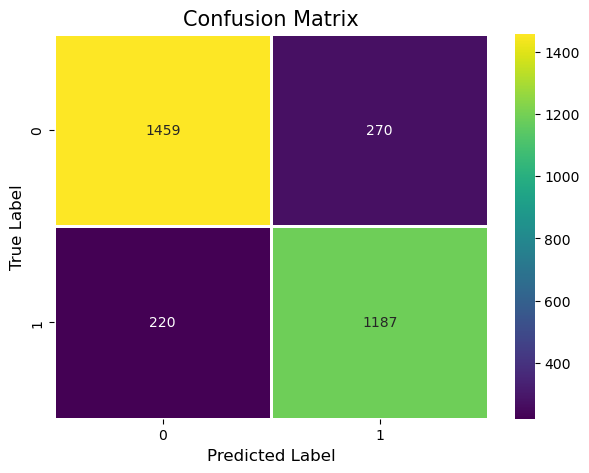

In [41]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

Again looking at our confusion matrix, we can understand why we have a high recall score. Looking at the true labels that are 0, aka `ABNO`, our model seems to have caught a majority of them.

Finally, looking into the ROC curve and AUC score. 

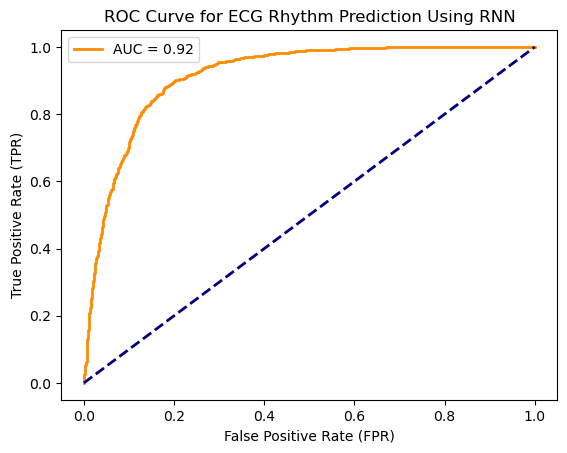

Area under curve (AUC):0.9161586926147582



In [43]:
fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 1])
roc_auc = roc_auc_score(y_test, predict_probas[:, 1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Our high AUC score is suggestive that our model is great at predicting normal ECGs being actually normal and abnormal ECGs being actually abnormal. This gives us confidence that our model is representing our data well. 

We will document down our models as we go. 

| Model | Notes                  | Loss | LR    | Train Accuracy | Test Accuracy | Recall |
|-------|------------------------|------|-------|----------------|---------------|--------|
| 1     | relu, softmax          | SCCE | 0.001 | 82             | 84            | 84     |

#### Save model as pickle

- https://edwarda-johnson.medium.com/ai-as-ghostwriter-different-ways-to-save-your-machine-learning-model-f8d4432e893

We can save our models as pickle files for using them to predict in the future using the following code below. 

In [46]:
with open('rnn_model.pkl', 'wb') as file:
    pickle.dump(rnn_model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
......gru_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......sparse_categorical_accuracy
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........1

To reload our model, we can use the following code: 

In [47]:
new_rnn_model = pickle.load(open('rnn_model.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-07-01 01:42:44         5947
metadata.json                                  2024-07-01 01:42:44           64
variables.h5                                   2024-07-01 01:42:44        88312
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......gru
.........cell
............vars
...............0
...............1
..........

In [48]:
new_rnn_model.predict(X_test)

98/98 [==============================] - 3s 27ms/step


array([[0.1318157 , 0.8681843 ],
       [0.9760384 , 0.02396154],
       [0.1650286 , 0.8349713 ],
       ...,
       [0.27087963, 0.7291203 ],
       [0.12843953, 0.87156045],
       [0.9007669 , 0.09923314]], dtype=float32)

We can confirm that our pickle file can predict scores and that our first RNN model is saved. Let's do another model.

<a id='model2'></a>
### Second Model

Moving on to model two, in this next model, we make appropriate adjustments to a few parameters to allow a better performing model. The following changes include:
- **Loss function**: `SparseCategoricalCrossentropy()` -> `BinaryCrossentropy()`
- **Metric**: `SparseCategoricalAccuracy()` -> `BinaryAccuracy()` 
- **Learning Rate**: `0.001` -> `0.005`
- **Output layer**: `softmax` -> `sigmoid`

The main difference in this model is using a sigmoid activation function and binary crossentropy. 

In [215]:
rnn_model_2 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')],
)

In [216]:
lr = 0.005
epoch = 20

In [217]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_2.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=lr),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.5),]
             #keras.metrics.Recall()]
)

Training our neural network with our data set now. 

In [218]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=5,
                                          #mode='max'
)

# Fit our model, adding a validation set as well 
history = rnn_model_2.fit(X_train, 
                    y_train, 
                    batch_size=64,
                    epochs=epoch, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - binary_accuracy: 0.5296 - loss: 0.7451 - val_binary_accuracy: 0.5482 - val_loss: 0.6892
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - binary_accuracy: 0.5483 - loss: 0.6925 - val_binary_accuracy: 0.5482 - val_loss: 0.6906
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - binary_accuracy: 0.5854 - loss: 0.6539 - val_binary_accuracy: 0.5482 - val_loss: 2.8155
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - binary_accuracy: 0.7248 - loss: 0.5406 - val_binary_accuracy: 0.7259 - val_loss: 0.5437
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - binary_accuracy: 0.7727 - loss: 0.4819 - val_binary_accuracy: 0.5817 - val_loss: 0.8904
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - binary_accuracy: 0.8105 - loss: 0.4322 - val_binary_accuracy: 0.7514 - val_loss: 0.5362
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - binary_accuracy: 0.8171 - loss: 0.4174 - val_binary_accuracy: 0.7554 - va

In [219]:
rnn_model_2.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_40 (GRU)                    │ (None, 1000, 16)       │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 1000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 1000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,885 (34.71 KB)

 Trainable params: 2,929 (11.44 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 5,860 (22.89 KB)

In [220]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmin(history.history['val_loss'])]
result = rnn_model_2.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8284
Test Accuracy: 0.8367


This time our accuracy became slightly lower for testing but our training accuracy is still relatively the same. 

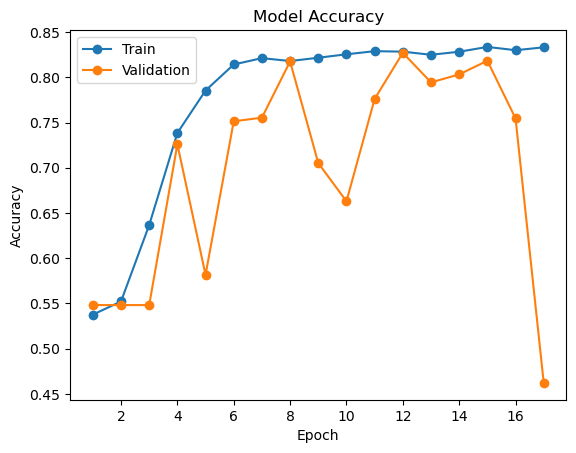

In [221]:
epochs = range(1, len(history.history['binary_accuracy'])+1)

# Plotting accuracy function 
plt.plot(epochs, history.history['binary_accuracy'], marker='o')
plt.plot(epochs, history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Looking at the model accuracy we see a lot of fluctuations during the epochs, the model has generally been improving along with the training set though until the end. At this moment, it is unknown why these drops appear. 

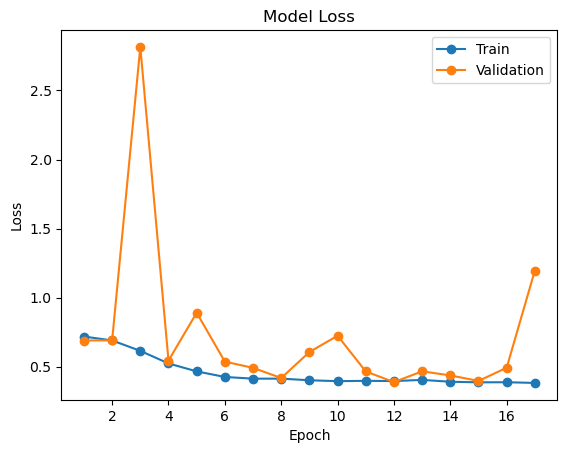

In [222]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

Again showing the major increase in validation loss. However, in other areas of the graph, there has been steady improvements in the loss. 

Next, looking into the confusion matrix.

In [223]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_2.predict(X_test)
binary_array = (predict_probas > 0.5).astype(int).reshape(-1) # Binary classification requires only has 1 output

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


,Predicted Abnormal,Predicted Normal
True Abnormal,1309,420
True Normal,92,1315


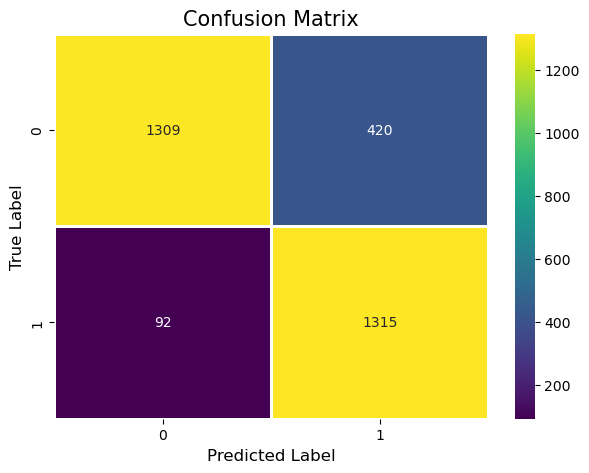

In [224]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [225]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1729
           1       0.76      0.93      0.84      1407

    accuracy                           0.84      3136
   macro avg       0.85      0.85      0.84      3136
weighted avg       0.86      0.84      0.84      3136



Looking at our confusion matrix and classification report above, we see a relatively low score for recall on the abnormal samples (`class 0`). This is not a great model for us, since we want our model to be sensitive of the smallest possibility for having an abnormal ECG. Test accuracy score is only a small percent lower than our first model, therefore it should not make a huge difference which model we choose.

Let's look into the ROC curve for our model.

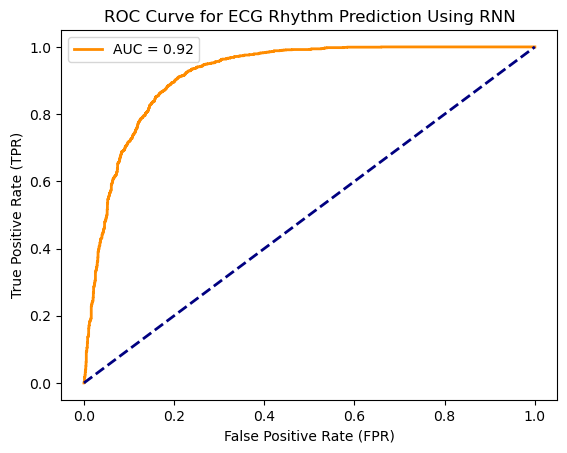

Area under curve (AUC):0.9180070481271243



In [226]:
# ROC and AUC scores
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

AUC scores are also really high, giving us confidence that we can classify signals correctly. 

Let's save this model as well.

In [229]:
# Save model
with open('new_model_2.pkl', 'wb') as file:
    pickle.dump(rnn_model_2, file)

Evaluating our model above, we see that this second model has roughly the same accuracy score as our first model. However, the recall score for `class 0`, i.e. abnormal ECGs is a lot lower. This is not what we're looking for, we intend to have a higher recall score so that we can capture as many abnormal ECGs as possible. To adjust for this, we can change our threshold in our binary classification. In our model metrics, let us change the threshold for classifying a class from `class 0` to `class 1` 0.1 higher. This means that now it would take more convincing by the model to classify an ECG to be normal vs abnormal, that is, we will increase the number of ECGs being classified as abnormal which is exactly what we want. 

Below we actually document a few more models that were ran that got overwritten by other code. We keep track of the activation functions used, loss, learning rate, and training and testing accuracy. 

| Model | Notes                  | Loss | LR    | Train Accuracy | Test Accuracy | Recall | File        |
|-------|------------------------|------|-------|----------------|---------------|--------|-------------|
| 1     | relu, softmax          | SCCE | 0.001 | 82             | 84            | 84     | rnn_model   |
| 2     | relu, sigmoid          | BCE  | 0.005 | 83             | 84            | 76     | new_model_2 |

<a id='third'></a>
### Third Model 
- Optimizing for `recall` metric by adjusting threshold on binary classification

In [326]:
# Revised RNN model, optimizing for recall 
rnn_model_3 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')],
)

In [327]:
lr = 0.005
epoch = 25
threshold = 0.6

In [328]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_3.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=lr),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(threshold=threshold),] # increasing threshold for classification
             #keras.metrics.Recall()]
)

Training our neural network with our data set now. 

In [329]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=5,
                                          mode='min'
)

# Fit our model, adding a validation set as well 
history = rnn_model_3.fit(X_train, 
                    y_train, 
                    batch_size=64,
                    epochs=epoch, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - binary_accuracy: 0.5232 - loss: 0.8346 - val_binary_accuracy: 0.5482 - val_loss: 0.9182
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - binary_accuracy: 0.5679 - loss: 0.6591 - val_binary_accuracy: 0.5490 - val_loss: 0.6556
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - binary_accuracy: 0.6493 - loss: 0.5798 - val_binary_accuracy: 0.5482 - val_loss: 2.5660
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - binary_accuracy: 0.7381 - loss: 0.5101 - val_binary_accuracy: 0.5482 - val_loss: 1.3178
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - binary_accuracy: 0.7901 - loss: 0.4507 - val_binary_accuracy: 0.8104 - val_loss: 0.4453
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - binary_accuracy: 0.8044 - loss: 0.4210 - val_binary_accuracy: 0.6653 - val_loss: 0.5468
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - binary_accuracy: 0.8111 - loss: 0.4123 - val_binary_accuracy: 0.6343 - va

In [330]:
rnn_model_3.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_66 (GRU)                    │ (None, 1000, 16)       │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 1000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 1000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_67 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,885 (34.71 KB)

 Trainable params: 2,929 (11.44 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 5,860 (22.89 KB)

In [331]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmax(history.history['val_binary_accuracy'])]
result = rnn_model_3.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8288
Test Accuracy: 0.8498


> This is our **highest accuracy** thus far at **85%**!

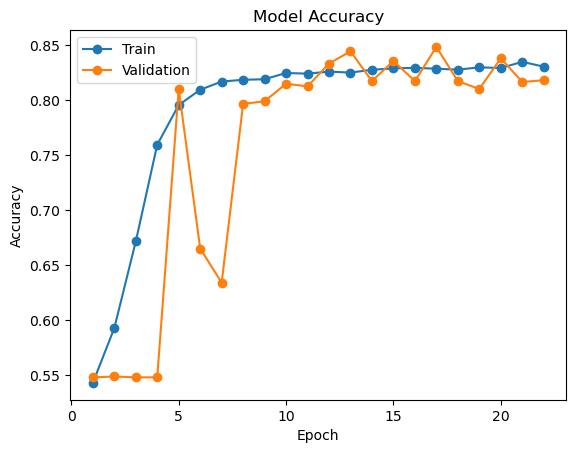

In [332]:
epochs = range(1, len(history.history['binary_accuracy'])+1)

# Plotting accuracy function 
plt.plot(epochs, history.history['binary_accuracy'], marker='o')
plt.plot(epochs, history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Looking at the model accuracy we see that other than a massive drop in accuracy during one of the epochs, the model has generally been improving along with the training set. At this moment, it is unknown why this drop appears. 

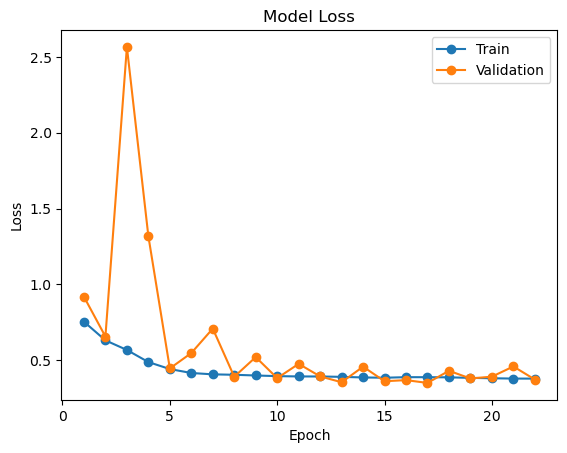

In [333]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

Again showing the major increase in validation score, it is still unknown where this comes from. However, in other areas of the graph, there has been steady improvements in the loss. We note that there is a continuous small oscillation of the validation loss around the training loss value as the epochs go. 

Below we actually document a few more models that were ran that got overwritten by other code. We keep track of the activation functions used, loss, learning rate, and training and testing accuracy. 

| Model | Activation             | Loss | LR    | Train Accuracy | Test Accuracy | AUC | File   |
|-------|------------------------|------|-------|----------------|---------------|-----|--------|
| 1     | relu, softmax          | SCCE | 0.01  | 80.58          | 80.10         | 90  | model  |
| 2     | relu, sigmoid, softmax | SCCE | 0.01  | 71.29          | 74.90         | --- | ------ | 
| 3     | relu, sigmoid          | SCCE | 0.005 | 81.24          | 82.53         | 70  | model2 |
| 4     | relu, sigmoid          | BCE  | 0.005 | 82.01          | 80.74         | 88  | model3 |

Next, looking into the confusion matrix.

In [334]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_3.predict(X_test)
binary_array = (predict_probas > 0.6).astype(int).reshape(-1) # Binary classification requires only has 1 output

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


,Predicted Abnormal,Predicted Normal
True Abnormal,1471,258
True Normal,213,1194


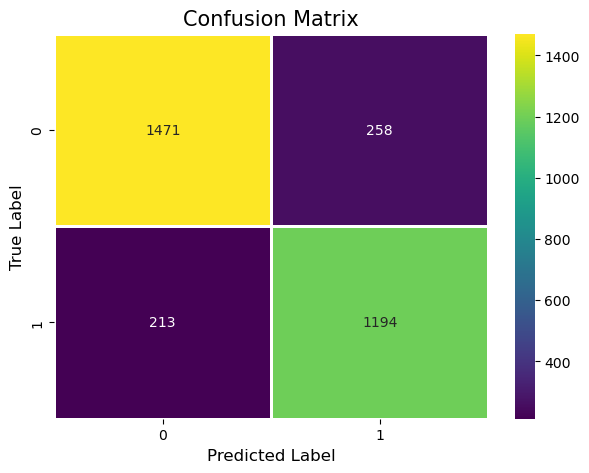

In [335]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [336]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1729
           1       0.82      0.85      0.84      1407

    accuracy                           0.85      3136
   macro avg       0.85      0.85      0.85      3136
weighted avg       0.85      0.85      0.85      3136



Looking at our confusion matrix and classification report above, we see incredibly high scores for recall on the abnormal samples. Again this is great for us as we want our model to be sensitive of these smallest possibility for having an abnormal ECG. Test accuracy scores remain the same, suggesting that we can choose between models depending on our preference.

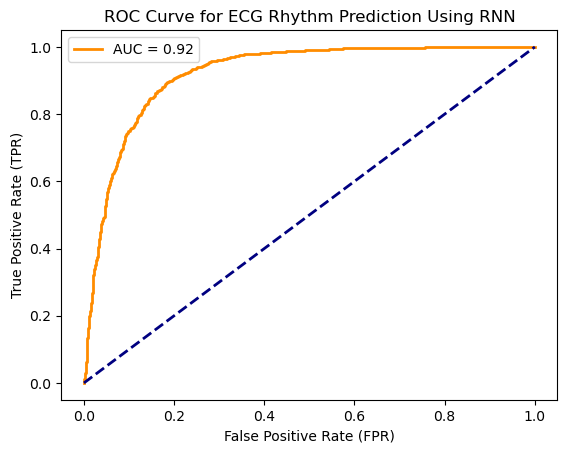

Area under curve (AUC):0.9212744013552004



In [337]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

AUC scores are also really high, giving us confidence that we can classify signals correctly. 

Let's save this model as well.

In [338]:
# Save model
with open('rnn_binary3.pkl', 'wb') as file:
    pickle.dump(rnn_model_3, file)

Keeping track of our model performances:

| Model | Notes                        | Loss | LR    | Train Accuracy | Test Accuracy | Recall | File        |
|-------|------------------------------|------|-------|----------------|---------------|--------|-------------|
| 1     | relu, softmax                | SCCE | 0.001 | 82             | 84            | 84     | rnn_model   |
| 2     | relu, sigmoid                | BCE  | 0.005 | 83             | 84            | 76     | new_model_2 |
| 3     | relu, sigmoid, 0.6 threshold | BCE  | 0.005 | 83             | 85            | 85     | rnn_binary3 |

<a id='gridsearch'></a>
### Using GridSearchCV

Now we attempt to perform a gridsearch. Below we use a gridsearch to try to look for the best performing model parameters. We utilize another package known as `scikeras`. 

In [15]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Setting random seed for reproducibility
tf.random.set_seed(42)

`scikeras` has a specific format for using `GridSearchCV` with, we will follow the guide outlined [here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) for different parameter optimizations. First we need to create a function that creates our neural network when called upon. 

In [61]:
def create_model():
    
    # Create model
    model = keras.Sequential()
    # the intermediate recurrent layers should return full sequences
    model.add(GRU(16, activation='relu', input_shape=(1000, 1), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # the last recurrent layer only returns the final output
    model.add(GRU(16, activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # output layer
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

We set our callback requirements and parameter grid. 

In [81]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Set our parameter grid with different batch sizes, epochs and learning rate
param_grid = dict(batch_size=[32, 64, 128], 
                  epochs=[25, 50], 
                  optimizer__learning_rate=[0.0001, 0.001, 0.005]
)

# Create an instance of the KerasClassifier to be used in GridSearchCV
models = KerasClassifier(model=create_model, 
                         optimizer="Adam", #[keras.optimizers.Adam(learning_rate=0.0001)], 
                         validation_split=0.2, 
                         callbacks=[callbacks],
                         loss=keras.losses.BinaryCrossentropy(),
                         metrics=[keras.metrics.BinaryAccuracy()],
                         batch_size=32,
                         epochs=25,
)

Next, we initialize the grid itself and fit it to our training data. 

In [82]:
# Initialize grid
grid = GridSearchCV(estimator=models, param_grid=param_grid, cv=3, verbose=3, n_jobs=3)

Let's take a look at our grid and model structure.

In [83]:
# Grid structure
grid

GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=32, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x2d56d4280>], epochs=25, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x2d56d7730>, metrics=[<BinaryAccuracy name=binary_accuracy>], model=<function create_model at 0x2d5548e50>, optimizer='Adam', validation_split=0.2),
             n_jobs=3,
             param_grid={'batch_size': [32, 64, 128], 'epochs': [25, 50],
                         'optimizer__learning_rate': [0.0001, 0.001, 0.005]},
             verbose=3)

In [84]:
# Fit grid
grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.0001;, score=nan total time=   0.1s
[CV 3/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.001;, score=nan total time=   0.1s
[CV 2/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.005;, score=nan total time=   0.1s
[CV 2/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.0001;, score=nan total time=   0.1s
[CV 2/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.001;, score=nan total time=   0.1s
[CV 3/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.005;, score=nan total time=   0.1s
[CV 3/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.0001;, score=nan total time=   0.1s
[CV 3/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.001;, score=nan total time=   0.1s
[CV 2/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.005;, score=nan total time=   0.1s
[CV 3/3] END batch_size=64,

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - binary_accuracy: 0.5104 - loss: 0.9356 - val_binary_accuracy: 0.5499 - val_loss: 0.6885
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - binary_accuracy: 0.4897 - loss: 0.8847 - val_binary_accuracy: 0.4531 - val_loss: 0.7046
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - binary_accuracy: 0.5167 - loss: 0.7977 - val_binary_accuracy: 0.5496 - val_loss: 0.6873
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - binary_accuracy: 0.5068 - loss: 0.8413 - val_binary_accuracy: 0.4626 - val_loss: 0.7048
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - binary_accuracy: 0.4983 - loss: 0.8160 - val_binary_accuracy: 0.5439 - val_loss: 0.6888
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - binary_accuracy: 0.5176 - loss: 0.7720 - val_binary_accuracy: 0.5467 - val_loss: 0.6867
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - binary_accuracy: 0.5152 - loss: 0.7996 - val_binary_accuracy: 0.5117 - val_loss: 0.7

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 52/209 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - binary_accuracy: 0.5212 - loss: 0.7276Epoch 1/25


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - binary_accuracy: 0.5206 - loss: 0.7613 - val_binary_accuracy: 0.5481 - val_loss: 0.7069
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - binary_accuracy: 0.5176 - loss: 0.7337 - val_binary_accuracy: 0.5353 - val_loss: 0.6944
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/stepp - binary_accuracy: 0.4962 - loss: 0.827
197/209 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - binary_accuracy: 0.4962 - loss: 0.8276[CV 3/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.0001;, score=0.535 total time= 2.4min
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/stepp - binary_accuracy: 0.4963 - loss: 0.827
199/209 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - binary_accuracy: 0.4964 - loss: 0.8272[CV 1/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.0001;, score=0.562 total time= 2.4min
209/209 ━━━━━━━━━━━━━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - binary_accuracy: 0.4970 - loss: 0.8250 - val_binary_accuracy: 0.5496 - val_loss: 0.6881
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - binary_accuracy: 0.5260 - loss: 0.7310 - val_binary_accuracy: 0.5496 - val_loss: 0.6883
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - binary_accuracy: 0.5014 - loss: 0.7959 - val_binary_accuracy: 0.5493 - val_loss: 0.6887
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - binary_accuracy: 0.5126 - loss: 0.7890 - val_binary_accuracy: 0.5374 - val_loss: 0.6930
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - binary_accuracy: 0.5444 - loss: 0.7059 - val_binary_accuracy: 0.5484 - val_loss: 0.6867
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - binary_accuracy: 0.5281 - loss: 0.7207 - val_binary_accuracy: 0.5559 - val_loss: 0.6867
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - binary_accuracy: 0.5256 - loss: 0.7236 - val_binary_accuracy: 

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.001;, score=0.573 total time= 3.5min
Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - binary_accuracy: 0.5478 - loss: 0.6882 - val_binary_accuracy: 0.5559 - val_loss: 0.6793
Epoch 9/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - binary_accuracy: 0.5554 - loss: 0.6837 - val_binary_accuracy: 0.5574 - val_loss: 0.6833
Epoch 10/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - binary_accuracy: 0.5123 - loss: 0.7934 - val_binary_accuracy: 0.5490 - val_loss: 0.6889
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - binary_accuracy: 0.5613 - loss: 0.6852 - val_binary_accuracy: 0.5601 - val_loss: 0.6802
Epoch 10/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - binary_accuracy: 0.5602 - loss: 0.6859 - val_binary_accuracy: 0.5544 - val_loss: 0.6836
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/stepep - binary_accuracy: 0.5938 - loss: 0.670
 3

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - binary_accuracy: 0.5404 - loss: 0.6956 - val_binary_accuracy: 0.5413 - val_loss: 0.6891
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - binary_accuracy: 0.5729 - loss: 0.6796 - val_binary_accuracy: 0.5702 - val_loss: 0.6733
Epoch 11/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - binary_accuracy: 0.5236 - loss: 0.7518 - val_binary_accuracy: 0.5493 - val_loss: 0.6886
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - binary_accuracy: 0.5415 - loss: 0.6906 - val_binary_accuracy: 0.5508 - val_loss: 0.6861
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - binary_accuracy: 0.5868 - loss: 0.6680 - val_binary_accuracy: 0.6192 - val_loss: 0.5883
Epoch 12/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step - binary_accuracy: 0.5491 - loss: 0.6935 - val_binary_accuracy: 0.5266 - val_loss: 0.6899
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step - binary_accuracy: 0.5803 - loss: 0.6625 - val_binary_accuracy: 0.6764 - val_loss: 0

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - binary_accuracy: 0.8007 - loss: 0.4497 - val_binary_accuracy: 0.8008 - val_loss: 0.4255
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - binary_accuracy: 0.6234 - loss: 0.6406 - val_binary_accuracy: 0.6360 - val_loss: 0.6116
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - binary_accuracy: 0.5261 - loss: 0.7622 - val_binary_accuracy: 0.5607 - val_loss: 0.6895
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - binary_accuracy: 0.8088 - loss: 0.4276 - val_binary_accuracy: 0.6687 - val_loss: 0.6653
Epoch 9/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - binary_accuracy: 0.7469 - loss: 0.5132 - val_binary_accuracy: 0.5505 - val_loss: 0.9139
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - binary_accuracy: 0.5506 - loss: 0.6917 - val_binary_accuracy: 0.5487 - val_loss: 0.6870
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - binary_accuracy: 0.8161 - loss: 0.4108 - val_binary_accuracy: 0.7943 - val_loss: 0.4

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 170ms/step - binary_accuracy: 0.7090 - loss: 0.5512 - val_binary_accuracy: 0.6157 - val_loss: 0.8815
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 170ms/step - binary_accuracy: 0.8272 - loss: 0.4007 - val_binary_accuracy: 0.8026 - val_loss: 0.4421
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/stepep - binary_accuracy: 0.7629 - loss: 0.494
 43/209 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - binary_accuracy: 0.7632 - loss: 0.4942

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 1/3] END batch_size=32, epochs=25, optimizer__learning_rate=0.005;, score=0.820 total time= 7.6min
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step - binary_accuracy: 0.4989 - loss: 0.8802 - val_binary_accuracy: 0.4504 - val_loss: 0.6983
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 172ms/step - binary_accuracy: 0.7800 - loss: 0.4695 - val_binary_accuracy: 0.7095 - val_loss: 0.6325
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 172ms/step - binary_accuracy: 0.4932 - loss: 0.8183 - val_binary_accuracy: 0.4492 - val_loss: 0.7133
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - binary_accuracy: 0.5063 - loss: 0.7942 - val_binary_accuracy: 0.5493 - val_loss: 0.6894
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - binary_accuracy: 0.8183 - loss: 0.4113 - val_binary_accuracy: 0.8057 - val_loss: 0.4385
Epoch 9/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - binary_accuracy: 0.5010 - loss: 0.7947 - val_binary_accuracy: 0.4958 - val_loss: 0.7081
Epoch 4/50
209/209 ━━━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - binary_accuracy: 0.5244 - loss: 0.7402 - val_binary_accuracy: 0.5239 - val_loss: 0.6955
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - binary_accuracy: 0.5245 - loss: 0.7359 - val_binary_accuracy: 0.5487 - val_loss: 0.6895
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 176ms/step - binary_accuracy: 0.5118 - loss: 0.8895 - val_binary_accuracy: 0.4393 - val_loss: 0.7065
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - binary_accuracy: 0.5184 - loss: 0.7314 - val_binary_accuracy: 0.5383 - val_loss: 0.6899
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - binary_accuracy: 0.5307 - loss: 0.7335 - val_binary_accuracy: 0.5421 - val_loss: 0.6909
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/stepep - binary_accuracy: 0.5210 - loss: 0.827
 48/209 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - binary_accuracy: 0.5210 - loss: 0.8279

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.0001;, score=0.555 total time= 3.8min
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - binary_accuracy: 0.5178 - loss: 0.8227 - val_binary_accuracy: 0.4967 - val_loss: 0.7037
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - binary_accuracy: 0.5215 - loss: 0.7337 - val_binary_accuracy: 0.5401 - val_loss: 0.6881
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - binary_accuracy: 0.5116 - loss: 0.8092 - val_binary_accuracy: 0.5496 - val_loss: 0.7009
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - binary_accuracy: 0.5296 - loss: 0.7982 - val_binary_accuracy: 0.5039 - val_loss: 0.7078
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - binary_accuracy: 0.5200 - loss: 0.7274 - val_binary_accuracy: 0.5652 - val_loss: 0.6863
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - binary_accuracy: 0.5405 - loss: 0.7134 - val_binary_accuracy: 0.5490 - val_loss: 0.6981
Epoch 3/50
209/209 ━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - binary_accuracy: 0.6459 - loss: 0.6068 - val_binary_accuracy: 0.6699 - val_loss: 0.5936
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - binary_accuracy: 0.5245 - loss: 0.7381 - val_binary_accuracy: 0.5433 - val_loss: 0.6861
Epoch 12/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - binary_accuracy: 0.5075 - loss: 0.7757 - val_binary_accuracy: 0.5188 - val_loss: 0.6933
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - binary_accuracy: 0.6724 - loss: 0.5870 - val_binary_accuracy: 0.6980 - val_loss: 0.5905
Epoch 11/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - binary_accuracy: 0.5373 - loss: 0.7192 - val_binary_accuracy: 0.5481 - val_loss: 0.6858
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - binary_accuracy: 0.5340 - loss: 0.7181 - val_binary_accuracy: 0.5302 - val_loss: 0.6909
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - binary_accuracy: 0.7225 - loss: 0.5395 - val_binary_accuracy: 0.6346 - val_loss:

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - binary_accuracy: 0.5441 - loss: 0.7068 - val_binary_accuracy: 0.5601 - val_loss: 0.6819
Epoch 23/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - binary_accuracy: 0.6951 - loss: 0.5687 - val_binary_accuracy: 0.6677 - val_loss: 0.6267
Epoch 13/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - binary_accuracy: 0.5066 - loss: 0.8829 - val_binary_accuracy: 0.5607 - val_loss: 0.6886
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - binary_accuracy: 0.5261 - loss: 0.7114 - val_binary_accuracy: 0.5678 - val_loss: 0.6807
Epoch 24/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - binary_accuracy: 0.7533 - loss: 0.5066 - val_binary_accuracy: 0.6551 - val_loss: 0.6474
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/stepep - binary_accuracy: 0.5559 - loss: 0.710
 80/209 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - binary_accuracy: 0.5557 - loss: 0.7099

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.001;, score=0.663 total time= 8.0min
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - binary_accuracy: 0.5118 - loss: 0.7413 - val_binary_accuracy: 0.5607 - val_loss: 0.6862
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - binary_accuracy: 0.5459 - loss: 0.7084 - val_binary_accuracy: 0.5678 - val_loss: 0.6808
Epoch 25/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - binary_accuracy: 0.5317 - loss: 0.7588 - val_binary_accuracy: 0.5496 - val_loss: 0.6900
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - binary_accuracy: 0.5478 - loss: 0.7146 - val_binary_accuracy: 0.5583 - val_loss: 0.6856
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - binary_accuracy: 0.5476 - loss: 0.7034 - val_binary_accuracy: 0.5660 - val_loss: 0.6807
Epoch 26/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - binary_accuracy: 0.5448 - loss: 0.6852 - val_binary_accuracy: 0.5484 - val_loss: 0.6741
Epoch 3/50
209/209 ━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.6937 - loss: 0.5703 - val_binary_accuracy: 0.6800 - val_loss: 0.6011
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.5454 - loss: 0.6901 - val_binary_accuracy: 0.5726 - val_loss: 0.6792
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 154ms/step - binary_accuracy: 0.5344 - loss: 0.7336 - val_binary_accuracy: 0.5493 - val_loss: 0.6888
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.7066 - loss: 0.5590 - val_binary_accuracy: 0.7626 - val_loss: 0.4991
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - binary_accuracy: 0.5626 - loss: 0.6857 - val_binary_accuracy: 0.5708 - val_loss: 0.6779
Epoch 10/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - binary_accuracy: 0.5398 - loss: 0.6960 - val_binary_accuracy: 0.5463 - val_loss: 0.6870
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.7124 - loss: 0.5571 - val_binary_accuracy: 0.5508 - val_loss: 1.

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.8191 - loss: 0.4195 - val_binary_accuracy: 0.6208 - val_loss: 0.7194
Epoch 15/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - binary_accuracy: 0.7561 - loss: 0.5067 - val_binary_accuracy: 0.7920 - val_loss: 0.4461
Epoch 17/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - binary_accuracy: 0.5242 - loss: 0.7275 - val_binary_accuracy: 0.5403 - val_loss: 0.6880
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - binary_accuracy: 0.8142 - loss: 0.4148 - val_binary_accuracy: 0.7368 - val_loss: 0.5370
Epoch 16/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - binary_accuracy: 0.7808 - loss: 0.4664 - val_binary_accuracy: 0.5786 - val_loss: 1.0662
Epoch 18/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - binary_accuracy: 0.5670 - loss: 0.6677 - val_binary_accuracy: 0.4949 - val_loss: 0.6849
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - binary_accuracy: 0.8176 - loss: 0.4124 - val_binary_accuracy: 0.7984 - val_loss:

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - binary_accuracy: 0.6083 - loss: 0.6288 - val_binary_accuracy: 0.5607 - val_loss: 0.8242
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - binary_accuracy: 0.4666 - loss: 0.8300 - val_binary_accuracy: 0.4498 - val_loss: 0.7163
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - binary_accuracy: 0.8108 - loss: 0.4318 - val_binary_accuracy: 0.7382 - val_loss: 0.5718
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 16.
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/stepep - binary_accuracy: 0.6560 - loss: 0.593
[CV 3/3] END batch_size=32, epochs=50, optimizer__learning_rate=0.001;, score=0.785 total time=10.4min
Epoch 1/25
 25/105 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - binary_accuracy: 0.4838 - loss: 0.7894

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.4991 - loss: 0.7739 - val_binary_accuracy: 0.4492 - val_loss: 0.7240
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.6698 - loss: 0.5852 - val_binary_accuracy: 0.7274 - val_loss: 0.5302
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - binary_accuracy: 0.5090 - loss: 0.9012 - val_binary_accuracy: 0.4507 - val_loss: 0.7038
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - binary_accuracy: 0.5293 - loss: 0.7431 - val_binary_accuracy: 0.4498 - val_loss: 0.7164
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.5183 - loss: 0.8231 - val_binary_accuracy: 0.4501 - val_loss: 0.7037
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - binary_accuracy: 0.7233 - loss: 0.5373 - val_binary_accuracy: 0.5918 - val_loss: 0.9560
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - binary_accuracy: 0.5074 - loss: 0.7631 - val_binary_accuracy: 0.4516 - val_loss: 0.7

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.5238 - loss: 0.7292 - val_binary_accuracy: 0.4886 - val_loss: 0.6962
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.5095 - loss: 0.7774 - val_binary_accuracy: 0.5415 - val_loss: 0.6950
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - binary_accuracy: 0.5373 - loss: 0.7209 - val_binary_accuracy: 0.5257 - val_loss: 0.6926
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step - binary_accuracy: 0.5375 - loss: 0.7622 - val_binary_accuracy: 0.4393 - val_loss: 0.6942
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 256ms/step - binary_accuracy: 0.5120 - loss: 0.7704 - val_binary_accuracy: 0.5415 - val_loss: 0.6969
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - binary_accuracy: 0.5243 - loss: 0.7322 - val_binary_accuracy: 0.5371 - val_loss: 0.6907
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - binary_accuracy: 0.5290 - loss: 0.7478 - val_binary_accuracy: 0.4836 - val_loss: 0.6

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.5310 - loss: 0.7217 - val_binary_accuracy: 0.5401 - val_loss: 0.6909
Epoch 10/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.5297 - loss: 0.7353 - val_binary_accuracy: 0.5320 - val_loss: 0.6903
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - binary_accuracy: 0.5013 - loss: 0.7971 - val_binary_accuracy: 0.5502 - val_loss: 0.6900
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - binary_accuracy: 0.5364 - loss: 0.7170 - val_binary_accuracy: 0.5520 - val_loss: 0.6890
Epoch 11/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - binary_accuracy: 0.5245 - loss: 0.7231 - val_binary_accuracy: 0.5445 - val_loss: 0.6865
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - binary_accuracy: 0.5177 - loss: 0.7337 - val_binary_accuracy: 0.5299 - val_loss: 0.6917
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.5346 - loss: 0.7156 - val_binary_accuracy: 0.5538 - 

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 93/105 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - binary_accuracy: 0.5354 - loss: 0.7100[CV 1/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.001;, score=0.556 total time= 1.9min
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.5460 - loss: 0.7127 - val_binary_accuracy: 0.5592 - val_loss: 0.6879
Epoch 14/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - binary_accuracy: 0.5354 - loss: 0.7103 - val_binary_accuracy: 0.5517 - val_loss: 0.6840
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - binary_accuracy: 0.5106 - loss: 0.7986 - val_binary_accuracy: 0.5493 - val_loss: 0.6888
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - binary_accuracy: 0.5360 - loss: 0.7162 - val_binary_accuracy: 0.5532 - val_loss: 0.6883
Epoch 15/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - binary_accuracy: 0.5373 - loss: 0.7105 - val_binary_accuracy: 0.5666 - val_loss: 0.6829
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - binary_accuracy: 0.5358 - loss

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - binary_accuracy: 0.5422 - loss: 0.6926 - val_binary_accuracy: 0.5547 - val_loss: 0.6829
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.5420 - loss: 0.7061 - val_binary_accuracy: 0.5580 - val_loss: 0.6854
Epoch 22/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 251ms/step - binary_accuracy: 0.5220 - loss: 0.7831 - val_binary_accuracy: 0.5607 - val_loss: 0.6876
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 277ms/step - binary_accuracy: 0.5590 - loss: 0.6890 - val_binary_accuracy: 0.5625 - val_loss: 0.6819
Epoch 10/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - binary_accuracy: 0.5275 - loss: 0.7151 - val_binary_accuracy: 0.5580 - val_loss: 0.6853
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 19.
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/stepstep - binary_accuracy: 0.5817 - loss: 0.678


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 1/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.0001;, score=0.561 total time=10.0min
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 277ms/step - binary_accuracy: 0.5392 - loss: 0.7344 - val_binary_accuracy: 0.5553 - val_loss: 0.6877
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - binary_accuracy: 0.5693 - loss: 0.6844 - val_binary_accuracy: 0.5511 - val_loss: 0.6828
Epoch 11/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - binary_accuracy: 0.5388 - loss: 0.7227 - val_binary_accuracy: 0.5475 - val_loss: 0.6864
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step - binary_accuracy: 0.5234 - loss: 0.7469 - val_binary_accuracy: 0.5496 - val_loss: 0.6885
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - binary_accuracy: 0.5486 - loss: 0.6886 - val_binary_accuracy: 0.5660 - val_loss: 0.6805
Epoch 12/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - binary_accuracy: 0.5376 - loss: 0.7179 - val_binary_accuracy: 0.5625 - val_loss: 0.6847
Epoch 5/25
105/105 ━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - binary_accuracy: 0.5826 - loss: 0.6732 - val_binary_accuracy: 0.5678 - val_loss: 0.6610
Epoch 15/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - binary_accuracy: 0.5533 - loss: 0.6963 - val_binary_accuracy: 0.5666 - val_loss: 0.6815
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - binary_accuracy: 0.5217 - loss: 0.7823 - val_binary_accuracy: 0.5493 - val_loss: 0.6895
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.5882 - loss: 0.6621 - val_binary_accuracy: 0.6079 - val_loss: 0.6214
Epoch 16/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.5622 - loss: 0.6962 - val_binary_accuracy: 0.5571 - val_loss: 0.6803
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - binary_accuracy: 0.5322 - loss: 0.7016 - val_binary_accuracy: 0.5338 - val_loss: 0.6899
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.6246 - loss: 0.6214 - val_binary_accuracy: 0.6569 - val_loss: 0

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.6598 - loss: 0.6096 - val_binary_accuracy: 0.6515 - val_loss: 0.6801
Epoch 13/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.6517 - loss: 0.6049 - val_binary_accuracy: 0.6151 - val_loss: 0.6490
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step - binary_accuracy: 0.5095 - loss: 0.7731 - val_binary_accuracy: 0.5607 - val_loss: 0.6860
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.6750 - loss: 0.5861 - val_binary_accuracy: 0.6414 - val_loss: 0.6094
Epoch 14/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.7591 - loss: 0.5046 - val_binary_accuracy: 0.6479 - val_loss: 0.9641
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.5463 - loss: 0.6987 - val_binary_accuracy: 0.5607 - val_loss: 0.6857
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.7095 - loss: 0.5589 - val_binary_accuracy: 0.5541 - val_loss: 0

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 61/105 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - binary_accuracy: 0.5763 - loss: 0.6558[CV 2/3] END batch_size=64, epochs=25, optimizer__learning_rate=0.005;, score=0.608 total time= 4.1min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.5869 - loss: 0.6489 - val_binary_accuracy: 0.5093 - val_loss: 0.6794
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.7435 - loss: 0.5243 - val_binary_accuracy: 0.5386 - val_loss: 1.3462
Epoch 17/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 254ms/step - binary_accuracy: 0.5006 - loss: 0.8408 - val_binary_accuracy: 0.5263 - val_loss: 0.6934
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.5855 - loss: 0.6455 - val_binary_accuracy: 0.4907 - val_loss: 0.6961
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - binary_accuracy: 0.7487 - loss: 0.5195 - val_binary_accuracy: 0.5619 - val_loss: 1.6989
Epoch 18/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - binary_accuracy: 0.5087 - los

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - binary_accuracy: 0.4908 - loss: 0.7992 - val_binary_accuracy: 0.5293 - val_loss: 0.6911
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 266ms/step - binary_accuracy: 0.7024 - loss: 0.5610 - val_binary_accuracy: 0.6485 - val_loss: 0.6015
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 269ms/step - binary_accuracy: 0.4832 - loss: 0.9996 - val_binary_accuracy: 0.4513 - val_loss: 0.7418
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - binary_accuracy: 0.5173 - loss: 0.7716 - val_binary_accuracy: 0.5329 - val_loss: 0.6933
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - binary_accuracy: 0.6935 - loss: 0.5601 - val_binary_accuracy: 0.4782 - val_loss: 0.8343
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - binary_accuracy: 0.4922 - loss: 0.8813 - val_binary_accuracy: 0.4513 - val_loss: 0.7585
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - binary_accuracy: 0.5240 - loss: 0.7805 - val_binary_accuracy: 0.5329 - val_loss: 0.6

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 1/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.0001;, score=0.550 total time= 2.8min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - binary_accuracy: 0.7706 - loss: 0.4861 - val_binary_accuracy: 0.7639 - val_loss: 0.4702
Epoch 11/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - binary_accuracy: 0.5087 - loss: 0.8161 - val_binary_accuracy: 0.4501 - val_loss: 0.7463
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/steptep - binary_accuracy: 0.4825 - loss: 0.8934


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 49/105 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - binary_accuracy: 0.7998 - loss: 0.4542[CV 2/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.0001;, score=0.449 total time= 1.9min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - binary_accuracy: 0.4865 - loss: 0.8843 - val_binary_accuracy: 0.5583 - val_loss: 0.6864
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - binary_accuracy: 0.7925 - loss: 0.4617 - val_binary_accuracy: 0.7137 - val_loss: 0.5672
Epoch 12/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 244ms/step - binary_accuracy: 0.5245 - loss: 0.8144 - val_binary_accuracy: 0.5496 - val_loss: 0.6898
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 243ms/step - binary_accuracy: 0.5247 - loss: 0.7936 - val_binary_accuracy: 0.5571 - val_loss: 0.6860
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - binary_accuracy: 0.7923 - loss: 0.4489 - val_binary_accuracy: 0.7513 - val_loss: 0.5245
Epoch 13/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 241ms/step - binary_accuracy: 0.5242 - lo

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - binary_accuracy: 0.5261 - loss: 0.7684 - val_binary_accuracy: 0.5613 - val_loss: 0.6982
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/steptep - binary_accuracy: 0.8056 - loss: 0.4345
 28/105 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - binary_accuracy: 0.5234 - loss: 0.8547

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 3/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.0001;, score=0.542 total time= 2.2min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - binary_accuracy: 0.8056 - loss: 0.4341 - val_binary_accuracy: 0.7968 - val_loss: 0.4313
Epoch 16/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 254ms/step - binary_accuracy: 0.5151 - loss: 0.8163 - val_binary_accuracy: 0.5493 - val_loss: 0.6976
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - binary_accuracy: 0.8114 - loss: 0.4277 - val_binary_accuracy: 0.8010 - val_loss: 0.4238
Epoch 17/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 254ms/step - binary_accuracy: 0.4957 - loss: 0.7860 - val_binary_accuracy: 0.5607 - val_loss: 0.6905
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 266ms/step - binary_accuracy: 0.5116 - loss: 0.7389 - val_binary_accuracy: 0.5493 - val_loss: 0.6949
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 287ms/step - binary_accuracy: 0.8250 - loss: 0.4125 - val_binary_accuracy: 0.8081 - val_loss: 0.4030
Epoch 18/25
105/105 ━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - binary_accuracy: 0.5731 - loss: 0.6691 - val_binary_accuracy: 0.5511 - val_loss: 0.6706
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - binary_accuracy: 0.5563 - loss: 0.6851 - val_binary_accuracy: 0.5553 - val_loss: 0.6483
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - binary_accuracy: 0.5076 - loss: 0.7505 - val_binary_accuracy: 0.5496 - val_loss: 0.6887
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 432ms/step - binary_accuracy: 0.5623 - loss: 0.6589 - val_binary_accuracy: 0.5912 - val_loss: 0.6283
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - binary_accuracy: 0.5601 - loss: 0.6548 - val_binary_accuracy: 0.5947 - val_loss: 0.6264
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - binary_accuracy: 0.5589 - loss: 0.6890 - val_binary_accuracy: 0.5437 - val_loss: 0.6891
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 443ms/step - binary_accuracy: 0.5789 - loss: 0.6433 - val_binary_accuracy: 0.5457 - val_loss:

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 25/105 ━━━━━━━━━━━━━━━━━━━━ 35s 442ms/step - binary_accuracy: 0.6057 - loss: 0.6152[CV 1/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.005;, score=0.552 total time= 3.2min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - binary_accuracy: 0.5866 - loss: 0.6444 - val_binary_accuracy: 0.5816 - val_loss: 0.6482
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 11.
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/stepstep - binary_accuracy: 0.5104 - loss: 0.75
 50/105 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - binary_accuracy: 0.5106 - loss: 0.7587

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.001;, score=0.590 total time= 9.5min
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - binary_accuracy: 0.6062 - loss: 0.6173 - val_binary_accuracy: 0.5977 - val_loss: 0.6006
Epoch 15/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - binary_accuracy: 0.5161 - loss: 0.7370 - val_binary_accuracy: 0.5493 - val_loss: 0.6890
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - binary_accuracy: 0.5274 - loss: 0.7825 - val_binary_accuracy: 0.5571 - val_loss: 0.6908
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 450ms/step - binary_accuracy: 0.6173 - loss: 0.6192 - val_binary_accuracy: 0.6210 - val_loss: 0.6166
Epoch 16/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - binary_accuracy: 0.5363 - loss: 0.6911 - val_binary_accuracy: 0.5493 - val_loss: 0.6879
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 448ms/step - binary_accuracy: 0.5403 - loss: 0.7018 - val_binary_accuracy: 0.5607 - val_loss: 0.6883
Epoch 3/50
105/105 ━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 3/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.001;, score=0.598 total time=12.0min
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - binary_accuracy: 0.5535 - loss: nan - val_binary_accuracy: 0.5493 - val_loss: nan
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 421ms/step - binary_accuracy: 0.5396 - loss: 0.6917 - val_binary_accuracy: 0.5380 - val_loss: 0.6867
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 548ms/step - binary_accuracy: 0.5063 - loss: 0.8366 - val_binary_accuracy: 0.5496 - val_loss: 0.6883
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 424ms/step - binary_accuracy: 0.5584 - loss: nan - val_binary_accuracy: 0.5493 - val_loss: nan
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/stepp - binary_accuracy: 0.4964 - loss: 0.82247
 67/105 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - binary_accuracy: 0.5724 - loss: 0.6732[CV 2/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.005;, score=0.5

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 540ms/step - binary_accuracy: 0.4966 - loss: 0.8208 - val_binary_accuracy: 0.5496 - val_loss: 0.6904
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 424ms/step - binary_accuracy: 0.5819 - loss: 0.6671 - val_binary_accuracy: 0.4889 - val_loss: 1.1451
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 551ms/step - binary_accuracy: 0.5162 - loss: 0.8329 - val_binary_accuracy: 0.4919 - val_loss: 0.6936
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - binary_accuracy: 0.5197 - loss: 0.7923 - val_binary_accuracy: 0.5496 - val_loss: 0.6923
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 561ms/step - binary_accuracy: 0.5254 - loss: 0.7878 - val_binary_accuracy: 0.5129 - val_loss: 0.6933
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 566ms/step - binary_accuracy: 0.5330 - loss: 0.7717 - val_binary_accuracy: 0.5502 - val_loss: 0.6920
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
105/105 ━━━━━━━━━━━━━━━━━━━━ 46s 437ms/step - binary_accuracy: 0.659

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/stepep - binary_accuracy: 0.4888 - loss: 0.8
14/53 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - binary_accuracy: 0.4903 - loss: 0.8230[CV 3/3] END batch_size=64, epochs=50, optimizer__learning_rate=0.005;, score=0.551 total time= 4.7min
Epoch 1/25


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - binary_accuracy: 0.5071 - loss: 0.7891 - val_binary_accuracy: 0.5188 - val_loss: 0.6929
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - binary_accuracy: 0.5017 - loss: 0.7537 - val_binary_accuracy: 0.5607 - val_loss: 0.6901
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 577ms/step - binary_accuracy: 0.5085 - loss: 0.8149 - val_binary_accuracy: 0.5496 - val_loss: 0.6887
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - binary_accuracy: 0.5015 - loss: 0.7659 - val_binary_accuracy: 0.5182 - val_loss: 0.6928
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - binary_accuracy: 0.5042 - loss: 0.7512 - val_binary_accuracy: 0.5607 - val_loss: 0.6897
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - binary_accuracy: 0.5202 - loss: 0.7453 - val_binary_accuracy: 0.5496 - val_loss: 0.6883
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 572ms/step - binary_accuracy: 0.5070 - loss: 0.7553 - val_binary_accuracy: 0.5188 - val_loss: 0.6924
Epoch 6/25

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 3/3] END batch_size=128, epochs=25, optimizer__learning_rate=0.0001;, score=0.551 total time= 2.7min
Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - binary_accuracy: 0.5115 - loss: 0.7444 - val_binary_accuracy: 0.5158 - val_loss: 0.6922
Epoch 9/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - binary_accuracy: 0.5245 - loss: 0.7114 - val_binary_accuracy: 0.5496 - val_loss: 0.6881
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - binary_accuracy: 0.5082 - loss: 0.8881 - val_binary_accuracy: 0.5493 - val_loss: 0.6900
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 593ms/step - binary_accuracy: 0.5260 - loss: 0.7375 - val_binary_accuracy: 0.5158 - val_loss: 0.6935
Epoch 10/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 548ms/step - binary_accuracy: 0.5452 - loss: 0.7069 - val_binary_accuracy: 0.5490 - val_loss: 0.6877
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - binary_accuracy: 0.5238 - loss: 0.7602 - val_binary_accuracy: 0.5487 - val_loss: 0.6896
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=128, epochs=25, optimizer__learning_rate=0.0001;, score=0.539 total time= 5.0min
Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - binary_accuracy: 0.5360 - loss: 0.7081 - val_binary_accuracy: 0.5490 - val_loss: 0.6870
Epoch 9/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - binary_accuracy: 0.5379 - loss: 0.7273 - val_binary_accuracy: 0.5487 - val_loss: 0.6894
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - binary_accuracy: 0.5180 - loss: 0.8513 - val_binary_accuracy: 0.4363 - val_loss: 0.6945
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - binary_accuracy: 0.5384 - loss: 0.7054 - val_binary_accuracy: 0.5496 - val_loss: 0.6865
Epoch 10/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - binary_accuracy: 0.5346 - loss: 0.7297 - val_binary_accuracy: 0.5487 - val_loss: 0.6894
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - binary_accuracy: 0.5350 - loss: 0.7533 - val_binary_accuracy: 0.4375 - val_loss: 0.6960
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - binary_accuracy: 0.5513 - loss: 0.6840 - val_binary_accuracy: 0.5670 - val_loss: 0.6619
Epoch 18/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - binary_accuracy: 0.5553 - loss: 0.6979 - val_binary_accuracy: 0.5469 - val_loss: 0.6853
Epoch 13/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - binary_accuracy: 0.5181 - loss: 0.7509 - val_binary_accuracy: 0.5496 - val_loss: 0.6881
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - binary_accuracy: 0.5803 - loss: 0.6545 - val_binary_accuracy: 0.5873 - val_loss: 0.6405
Epoch 19/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - binary_accuracy: 0.5511 - loss: 0.6919 - val_binary_accuracy: 0.5571 - val_loss: 0.6825
 7/53 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - binary_accuracy: 0.5911 - loss: 0.6433Epoch 14/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - binary_accuracy: 0.5485 - loss: 0.6899 - val_binary_accuracy: 0.5496 - val_loss: 0.6891
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - binary_accur

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/stepep - binary_accuracy: 0.7495 - loss: 0.505


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/53 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - binary_accuracy: 0.7489 - loss: 0.5061[CV 2/3] END batch_size=128, epochs=25, optimizer__learning_rate=0.001;, score=0.590 total time= 6.9min
Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - binary_accuracy: 0.7454 - loss: 0.5104 - val_binary_accuracy: 0.5825 - val_loss: 0.7165
Epoch 10/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - binary_accuracy: 0.5353 - loss: 0.7697 - val_binary_accuracy: 0.5493 - val_loss: 0.6892
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - binary_accuracy: 0.5131 - loss: 0.7501 - val_binary_accuracy: 0.5607 - val_loss: 0.6872
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - binary_accuracy: 0.7899 - loss: 0.4553 - val_binary_accuracy: 0.5496 - val_loss: 0.7912
Epoch 11/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - binary_accuracy: 0.5365 - loss: 0.7116 - val_binary_accuracy: 0.5493 - val_loss: 0.6883
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - binary_accuracy: 0.5512 - loss: 0.6791 - v

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 2/3] END batch_size=128, epochs=25, optimizer__learning_rate=0.005;, score=0.549 total time= 2.4min
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - binary_accuracy: 0.6583 - loss: 0.5917 - val_binary_accuracy: 0.5320 - val_loss: 0.6852
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - binary_accuracy: 0.8195 - loss: 0.4072 - val_binary_accuracy: 0.7943 - val_loss: 0.4274
Epoch 17/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - binary_accuracy: 0.6702 - loss: 0.5835 - val_binary_accuracy: 0.4979 - val_loss: 0.6882
Epoch 9/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - binary_accuracy: 0.5099 - loss: 0.8064 - val_binary_accuracy: 0.5496 - val_loss: 0.6892
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - binary_accuracy: 0.8175 - loss: 0.3981 - val_binary_accuracy: 0.6986 - val_loss: 0.5697
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 14.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/stepp - binary_accuracy: 0.6831 - loss: 0.565
[CV 1/3] END b

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - binary_accuracy: 0.6854 - loss: 0.5646 - val_binary_accuracy: 0.6509 - val_loss: 0.6360
Epoch 10/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - binary_accuracy: 0.5046 - loss: 0.7788 - val_binary_accuracy: 0.5496 - val_loss: 0.6883
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - binary_accuracy: 0.4891 - loss: 0.7961 - val_binary_accuracy: 0.4507 - val_loss: 0.7044
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - binary_accuracy: 0.7065 - loss: 0.5502 - val_binary_accuracy: 0.6874 - val_loss: 0.5719
Epoch 11/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - binary_accuracy: 0.5009 - loss: 0.7795 - val_binary_accuracy: 0.5496 - val_loss: 0.6885
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 362ms/step - binary_accuracy: 0.4745 - loss: 0.7770 - val_binary_accuracy: 0.4507 - val_loss: 0.7158
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - binary_accuracy: 0.7297 - loss: 0.5304 - val_binary_accuracy: 0.5732 - val_loss: 0.7365
Epoch 12

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/53 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - binary_accuracy: 0.7434 - loss: 0.5192[CV 1/3] END batch_size=128, epochs=50, optimizer__learning_rate=0.0001;, score=0.552 total time= 1.7min
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - binary_accuracy: 0.4996 - loss: 0.7413 - val_binary_accuracy: 0.4507 - val_loss: 0.7328
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/stepp - binary_accuracy: 0.7462 - loss: 0.513


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/53 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - binary_accuracy: 0.4867 - loss: 0.8849[CV 2/3] END batch_size=128, epochs=50, optimizer__learning_rate=0.0001;, score=0.449 total time= 1.4min
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - binary_accuracy: 0.7463 - loss: 0.5133 - val_binary_accuracy: 0.5702 - val_loss: 0.9816
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 10.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/stepp - binary_accuracy: 0.4863 - loss: 0.882
[CV 3/3] END batch_size=128, epochs=25, optimizer__learning_rate=0.005;, score=0.676 total time= 4.3min
Epoch 1/50
10/53 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - binary_accuracy: 0.5076 - loss: 0.8407

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 379ms/step - binary_accuracy: 0.4862 - loss: 0.8822 - val_binary_accuracy: 0.4525 - val_loss: 0.6935
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - binary_accuracy: 0.5080 - loss: 0.8116 - val_binary_accuracy: 0.5443 - val_loss: 0.6919
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - binary_accuracy: 0.5258 - loss: 0.7929 - val_binary_accuracy: 0.5493 - val_loss: 0.6891
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - binary_accuracy: 0.4787 - loss: 0.8724 - val_binary_accuracy: 0.5194 - val_loss: 0.6926
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - binary_accuracy: 0.5250 - loss: 0.7569 - val_binary_accuracy: 0.4510 - val_loss: 0.6952
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - binary_accuracy: 0.5285 - loss: 0.7336 - val_binary_accuracy: 0.5493 - val_loss: 0.6921
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - binary_accuracy: 0.5051 - loss: 0.8314 - val_binary_accuracy: 0.5254 - val_loss: 0.6924
Epoch 4/50

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 362ms/step - binary_accuracy: 0.5314 - loss: 0.7162 - val_binary_accuracy: 0.5493 - val_loss: 0.6916
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/stepep - binary_accuracy: 0.5093 - loss: 0.85
10/53 ━━━━━━━━━━━━━━━━━━━━ 15s 362ms/step - binary_accuracy: 0.5101 - loss: 0.8544[CV 2/3] END batch_size=128, epochs=50, optimizer__learning_rate=0.001;, score=0.551 total time= 1.4min
Epoch 1/50


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - binary_accuracy: 0.5097 - loss: 0.8136 - val_binary_accuracy: 0.5206 - val_loss: 0.6943
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - binary_accuracy: 0.5094 - loss: 0.8115 - val_binary_accuracy: 0.5607 - val_loss: 0.6870
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - binary_accuracy: 0.5073 - loss: 0.7829 - val_binary_accuracy: 0.5176 - val_loss: 0.6963
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - binary_accuracy: 0.5106 - loss: 0.7706 - val_binary_accuracy: 0.5496 - val_loss: 0.6881
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/stepep - binary_accuracy: 0.4857 - loss: 0.736
18/53 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - binary_accuracy: 0.4988 - loss: 0.7523

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV 3/3] END batch_size=128, epochs=50, optimizer__learning_rate=0.0001;, score=0.521 total time= 2.1min
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - binary_accuracy: 0.5074 - loss: 0.7453 - val_binary_accuracy: 0.5607 - val_loss: 0.6861
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - binary_accuracy: 0.5361 - loss: 0.7085 - val_binary_accuracy: 0.5502 - val_loss: 0.6896
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 391ms/step - binary_accuracy: 0.5238 - loss: 0.8017 - val_binary_accuracy: 0.5493 - val_loss: 0.6887
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 437ms/step - binary_accuracy: 0.5251 - loss: 0.7309 - val_binary_accuracy: 0.5607 - val_loss: 0.6861
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 445ms/step - binary_accuracy: 0.5417 - loss: 0.7021 - val_binary_accuracy: 0.5496 - val_loss: 0.6880
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 459ms/step - binary_accuracy: 0.5431 - loss: 0.6965 - val_binary_accuracy: 0.5493 - val_loss: 0.6886
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━

/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - binary_accuracy: 0.5679 - loss: 0.6759 - val_binary_accuracy: 0.5505 - val_loss: 1.9542
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step_accuracy: 0.4453 - loss: 0.9116ss: 0.708
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 332ms/step - binary_accuracy: 0.5367 - loss: 0.7081 - val_binary_accuracy: 0.5583 - val_loss: 0.6842
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - binary_accuracy: 0.5268 - loss: 0.7685 - val_binary_accuracy: 0.5607 - val_loss: 0.6867
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - binary_accuracy: 0.5486 - loss: 0.6954 - val_binary_accuracy: 0.5595 - val_loss: 0.6837
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 332ms/step - binary_accuracy: 0.5537 - loss: 0.7039 - val_binary_accuracy: 0.5607 - val_loss: 0.6863
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - binary_accuracy: 0.5467 - loss: 0.6992 - val_binary_accuracy: 0.5547 - val_loss: 0.6836


/opt/anaconda3/envs/ecgcap/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - binary_accuracy: 0.5302 - loss: 0.7348 - val_binary_accuracy: 0.5448 - val_loss: 0.6896
Epoch 2/25
153/314 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - binary_accuracy: 0.5530 - loss: 0.6808[CV 3/3] END batch_size=128, epochs=50, optimizer__learning_rate=0.005;, score=0.551 total time= 1.5min
314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - binary_accuracy: 0.5703 - loss: 0.6676 - val_binary_accuracy: 0.4603 - val_loss: 1.2399
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - binary_accuracy: 0.7367 - loss: 0.5223 - val_binary_accuracy: 0.6150 - val_loss: 0.7791
Epoch 4/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - binary_accuracy: 0.7918 - loss: 0.4664 - val_binary_accuracy: 0.7760 - val_loss: 0.4854
Epoch 5/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - binary_accuracy: 0.8094 - loss: 0.4335 - val_binary_accuracy: 0.7047 - val_loss: 0.6794
Epoch 6/25
136/314 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - binary_accuracy: 0.7534 - loss: 0.4960[CV

GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=32, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x2d56d4280>], epochs=25, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x2d56d7730>, metrics=[<BinaryAccuracy name=binary_accuracy>], model=<function create_model at 0x2d5548e50>, optimizer='Adam', validation_split=0.2),
             n_jobs=3,
             param_grid={'batch_size': [32, 64, 128], 'epochs': [25, 50],
                         'optimizer__learning_rate': [0.0001, 0.001, 0.005]},
             verbose=3)

Looking at the best model the gridsearch found, we have:

In [91]:
# Best model
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.809584 using {'batch_size': 32, 'epochs': 25, 'optimizer__learning_rate': 0.005}


In [107]:
# The best model from gridsearch
grid.best_estimator_

KerasClassifier(
	model=<function create_model at 0x2d5548e50>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x2d55e5b40>
	metrics=[<BinaryAccuracy name=binary_accuracy>]
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x2d55e7df0>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=25
	class_weight=None
	optimizer__learning_rate=0.005
)

We will use the best model to evaluate our test set.

In [100]:
# Evaluate the model using the test data and generate predictions
train_accuracy = grid.best_score_
result = grid.score(X_test, y_test)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Train Accuracy: 0.8096
Test Accuracy: 0.8013


Let's look at the confusion matrix for this model.

In [113]:
# Calculate the predicted labels for each test image.
predictions = grid.predict(X_test)
#binary_array = (predict_probas > 0.7).astype(int).reshape(-1) # Binary classification requires only has 1 output

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predictions)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


,Predicted Abnormal,Predicted Normal
True Abnormal,1205,524
True Normal,99,1308


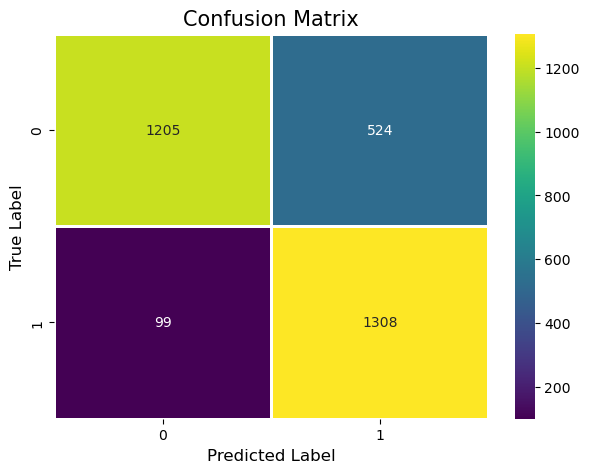

In [114]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

Looking at the confusion matrix above, we see that our model predicts more normal ECG when it is actually abnormal. Let's look into the classification report. 

In [115]:
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1729
           1       0.71      0.93      0.81      1407

    accuracy                           0.80      3136
   macro avg       0.82      0.81      0.80      3136
weighted avg       0.83      0.80      0.80      3136



From this classification report, we see that actually the grid search gave us a model that is less in our favour. Not only did the overall accuracy did not change but the model from the grid search has a much lower recall score for `class 0` which is our abnormal ECG class. We actually want to have a higher recall score for this in order to capture any thing that could possibly show signs of an abnormal heart. 

Looking into the ROC curve, we have

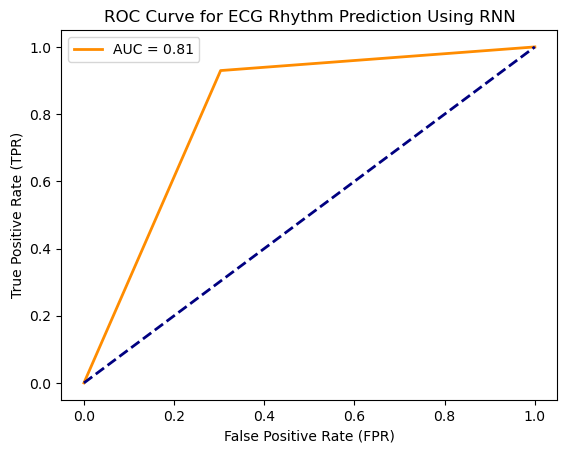

Area under curve (AUC):0.8132860854777586



In [116]:
fprs, tprs, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predict_probas)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Again this result is lower than the result we had before. 

We can still save the model for now using pickle. 

In [108]:
# Save model
with open('grid_search.pkl', 'wb') as file:
    pickle.dump(grid, file)

| Model | Notes                        | Loss | LR    | Train Accuracy | Test Accuracy | Recall | File        |
|-------|------------------------------|------|-------|----------------|---------------|--------|-------------|
| 1     | relu, softmax                | SCCE | 0.001 | 82             | 84            | 84     | rnn_model   |
| 2     | relu, sigmoid                | BCE  | 0.005 | 83             | 84            | 76     | new_model_2 |
| 3     | relu, sigmoid, 0.6 threshold | BCE  | 0.005 | 83             | 85            | 85     | rnn_binary3 |
| grid  | relu, sigmoid                | BCE  | both  | 81             | 80            | 70     | grid_search |

<a id='fourth'></a>
### Fourth Model
Knowing our results from our grid search, let us reconstruct our model using those parameters for another training. 

In [118]:
rnn_model_4 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(1, activation='sigmoid')],
)

In [119]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_4.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=grid.best_params_['optimizer__learning_rate']),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [120]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=25
)

# Fit our model, adding a validation set as well 
history = rnn_model_4.fit(X_train, 
                          y_train, 
                          batch_size=grid.best_params_['batch_size'],
                          epochs=grid.best_params_['epochs'], 
                          validation_split=0.2,
                          callbacks=[callbacks]
)

Epoch 1/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - binary_accuracy: 0.5257 - loss: 0.7301 - val_binary_accuracy: 0.5448 - val_loss: 0.6895
Epoch 2/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - binary_accuracy: 0.5485 - loss: 0.6893 - val_binary_accuracy: 0.5428 - val_loss: 0.7834
Epoch 3/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - binary_accuracy: 0.6265 - loss: 0.6306 - val_binary_accuracy: 0.4651 - val_loss: 1.1467
Epoch 4/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - binary_accuracy: 0.7196 - loss: 0.5543 - val_binary_accuracy: 0.7266 - val_loss: 0.5488
Epoch 5/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - binary_accuracy: 0.7511 - loss: 0.5145 - val_binary_accuracy: 0.4874 - val_loss: 1.2334
Epoch 6/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - binary_accuracy: 0.7795 - loss: 0.4843 - val_binary_accuracy: 0.6752 - val_loss: 0.6188
Epoch 7/25
314/314 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - binary_accuracy: 0.7957 - loss: 0.4542 - val_binary_accuracy: 0.6162 - va

In [121]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmax(history.history["binary_accuracy"])]
result = rnn_model_4.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8308
Test Accuracy: 0.8284


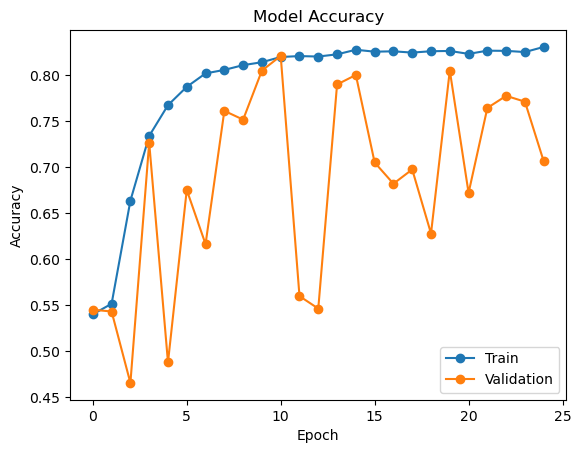

In [122]:
# Plotting accuracy function 
plt.plot(history.history['binary_accuracy'], marker='o')
plt.plot(history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

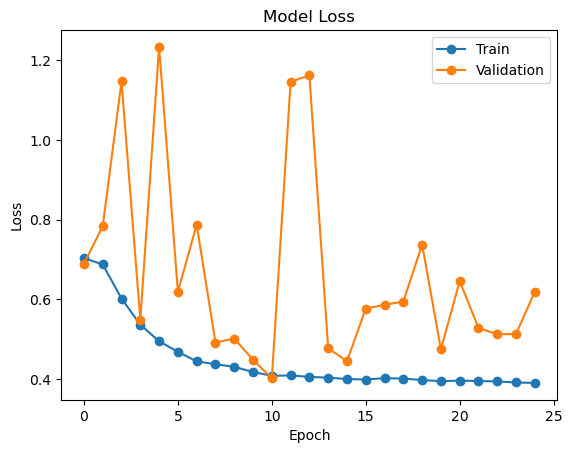

In [123]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

From the graphs above, we see major fluctuations in the validation set. The reason for this is still unknown and would be investigated. However, this is already not a good sign to see as it should be steady like the training accuracy and loss.

We can look into the confusion matrix and classification report in the mean time. 

In [124]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_4.predict(X_test)
binary_array = (predict_probas > 0.5).astype(int).reshape(-1) # Binary classification requires only has 1 output
#y_predict = np.argmax(predict_probas, axis=0)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


,Predicted Abnormal,Predicted Normal
True Abnormal,1443,286
True Normal,252,1155


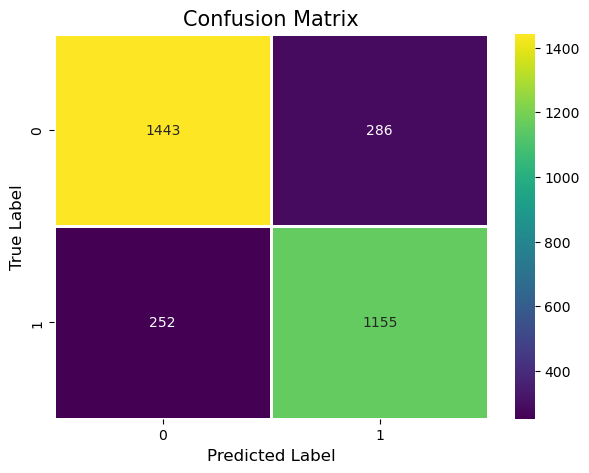

In [125]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [126]:
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1729
           1       0.80      0.82      0.81      1407

    accuracy                           0.83      3136
   macro avg       0.83      0.83      0.83      3136
weighted avg       0.83      0.83      0.83      3136



Through the classification report, we actually see decent accuracy scores for the test set as well as high recall score again for the abnormal class. Let's look into the AUC score. 

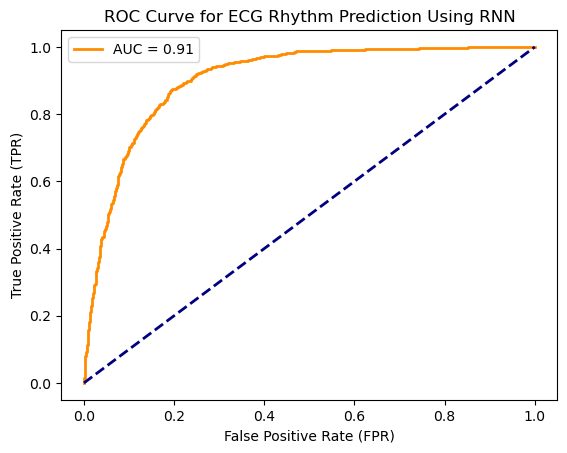

Area under curve (AUC):0.9058816468759237



In [127]:
fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Another high metric in AUC score, suggesting our model is good at classifying in the respective binary classifications. 

Saving the model

In [128]:
# Save model
with open('rnn_binary4.pkl', 'wb') as file:
    pickle.dump(rnn_model_4, file)

This model by our grid search does not seem promising as we see the accuracy and loss metric fluctuating a lot throughout the training process. In addition, our test accuracy scores are still lower than our previous models making it not the best model we can have so far.

Last model update: 

| Model | Notes                        | Loss | LR    | Train Accuracy | Test Accuracy | Recall | File        |
|-------|------------------------------|------|-------|----------------|---------------|--------|-------------|
| 1     | relu, softmax                | SCCE | 0.001 | 82             | 84            | 84     | rnn_model   |
| 2     | relu, sigmoid                | BCE  | 0.005 | 83             | 84            | 76     | new_model_2 |
| 3     | relu, sigmoid, 0.6 threshold | BCE  | 0.005 | 83             | 85            | 85     | rnn_binary3 |
| grid  | relu, sigmoid                | BCE  | both  | 81             | 80            | 70     | grid_search |
| 4     | relu, sigmoid                | BCE  | 0.005 | 83             | 83            | 83     | rnn_binary4 |

Our best model with the highest accuracy and recall score is still Model 3 where we adjusted our threshold value. For future considerations, we will update any new model with the 0.6 threshold as well as it has proven to give better results. 

<a id='summary'></a>
### Summary

Here we will provide a quick recap of our problem space and how our solution will help with the situation. 

Biomedical signals have always played an important role in many medical settings. One of the major type is an ECG, a non invasive procedure that can measure your heart rhythm potentially detecting heart abnormalities and other conditions about your body. However, traditionally, ECGs heavily relied of human interpretation. Medical professionals who may not be adequately trained may misinterpret ECG readings. Even under intense trainings, physicians, such as cardiologist, can also make mistakes too. We propose the solution of using data science tools to help us with identifying ECG signals and classifying them, thereby giving medical professionals a second line of confirmation when they are diagnosing. This can also be extended to the general public, implementing this feature in smart wearable devices, allow users to be notified if they may potentially have certain heart abnormalities given that the wearable device monitors the users heart rhythms in the form of ECGs. 

Starting from the beginning of our journey, we gathered a data set from PhysioNet called PTB-XL that consists of 21799 ECG entries. Since this data set contains signals that possibly have multiple diagnosis at once, we had to be extra careful of which data rows we wanted to train our models on. First, we combined two data sources where one included patient information, and the other the patients ECG diagnosis. This was done in the first notebook, `1 - Metadata_Annotations_Cleaning.ipynb`. We also did some preliminary data cleaning by reducing columns where ones that did not give us immediate useability for our ECG signals, were dropped. 

In the second notebook, `2 - Ecg_Cleaning.ipynb`, we performed some baseline exploratory data analysis by looking at data distributions and statistical tests. Through these tests, we were able to pin down the use case of Fourier Transforms for ECG signal cleaning. By creating functions that would take in a timeseries signal, it would clean a signal by removing noising background frequencies defined by the user. This allowed for better and more precise ECGs to be fed into our models for training, giving improved results. 

In the following notebook, `3 - Baseline_Modeling`, we begin modeling by choosing simple algorithms such as Logistic Regression to see how our data plays. For better modeling, we decided to implement a binning method that let's us bin our signal based on amplitude and see how classification algorithms perform on it. We split our modeling into two ways, multiclass classification or binary classification. In the multiclass method, we fully utilize the extensive coverage of signals that may show multiple heart condition at a time. This ended up with 10 diagnostic superclasses in our target variable. With major class imbalance, modeling with 10 classes became really difficult as our models show. In contrast, using binary classification, greatly increase our model performances leading to positive results. 

As a side detour, we took a chance at autoencoders in the next notebook `4 - Autoencoders`. Autoencoders, utilize a bottle neck in a neural network architecture where information is squeezed extensively forcing the model to only learn about important features of the data before it is asked to reconstruct the original signal. We experimented using our 10 classes and found it difficult to getting the neural network to perform well. Most of the iterations results in underfitting of the validation signal leading to over fitting of the model overall. 

Last but not least, we have our last notebook `5 - Recurrent Neural Networks` where we utilize recurrent neural networks for time series analysis, in our case ECG signals. This time we do not implement the binning method as RNNs process data in sequence, allowing us to feed in the raw data after it has been preprocessed. The results are the best models thus far of all the machine learning algorithms used. However, due to computation inefficiencies, the best model has yet been found through grid search. Although we can confidently say that the RNN models are best are predicting binary classification for our problem space. 

Nowing that heart related problems can change a person in a really short amount of time, we want to make sure that we can catch the issue right away. This is where our models come into play. They are optimized for higher recall score on the abnormal binary class. This means that our algorithm will have a higher chance of alerting someone if they may have the slightest chance of experiencing certain heart abnormalities. This is the goal of our project, to be able to predict ECG conditions acting as the first line of alert. Further implications, such as whether or not the person may about to experience a heart attack or not is left to physicians to determine. 